In [1]:
#hack till I make it a real package..
import os
import sys
sys.path.append("../../")
#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import jax 
import jax.numpy as jnp

jax.config.update('jax_disable_jit', False)
jax.config.update('jax_debug_nans', False)

import diffhydro as dh
from diffhydro.utils.io import athinput,athdf
%pylab inline


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
#load athena ICs
import h5py
import jax.numpy as jnp
from diffhydro.utils.io import athinput,athdf

athena_outputs_loc = "../../sims/sn_blast_cool_nocond/"

ic_filename = "multiblast.out3.00021.athdf"


ICs = athdf(athena_outputs_loc+ic_filename)



In [3]:

sol = jnp.zeros((5,100,100,100))
sol = sol.at[0].set(ICs["dens"])
sol = sol.at[-1].set(ICs["Etot"])

In [4]:
#this conduction is broken... :'(

eq = dh.equationmanager.EquationManager()
eq.thermal_conductivity_model = "ELBADRY"

#eq.box_size = (128.0, 256.0,1.0)
ss = dh.signal_speed_Rusanov
solver = dh.HLLC(equation_manager=eq,signal_speed=ss)
cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"))

conductive_flux = dh.ConductiveFlux(eq, None, None,zeta= 5.111496271545331e-12)

hydrosim = dh.hydro(n_super_step=int(100
                                    ),fluxes=[cf],use_mol=True)#splitting_schemes=[[2,1,1,2],[1,2,2,1],])

In [5]:
prim = eq.get_primitives_from_conservatives(sol)
T = eq.get_temperature(prim[-1],prim[0])

In [6]:
T.max()

Array(4609014.5, dtype=float32)

In [7]:

params = {}
q = hydrosim.evolve(sol,params)

In [8]:
conductive_flux.timestep(sol)

Array(4.7247786e-07, dtype=float32)

In [9]:

prim = eq.get_primitives_from_conservatives(q[0])
rho  = prim[0]
p    = prim[-1]
T    = eq.get_temperature(p, rho)

In [10]:

prim = eq.get_primitives_from_conservatives(q[0])
rho  = prim[0]
p    = prim[-1]
T    = eq.get_temperature(p, rho)

cp_m = eq.get_specific_heat_capacity(T)  # per-unit-mass c_p

# Unsaturated conductivity from the manager (face eval not required for dt)
kappa_unsat = eq.get_thermal_conductivity(T, prim)


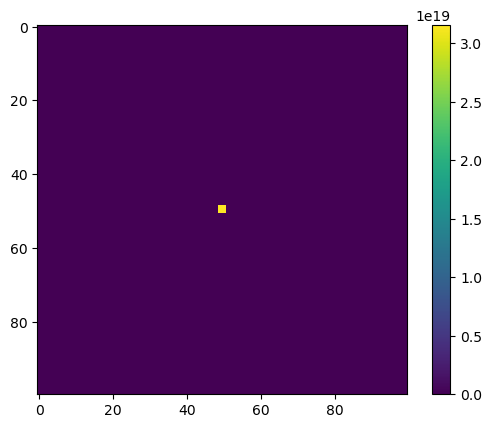

In [11]:
imshow(kappa_unsat[50])
colorbar()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


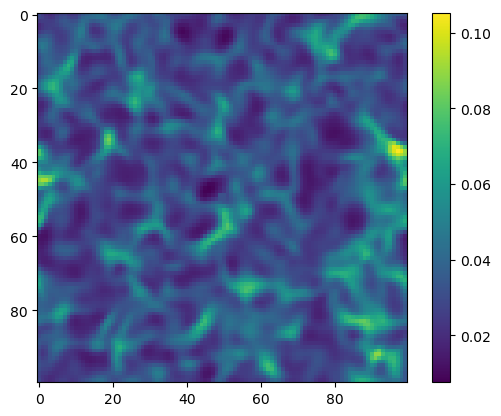

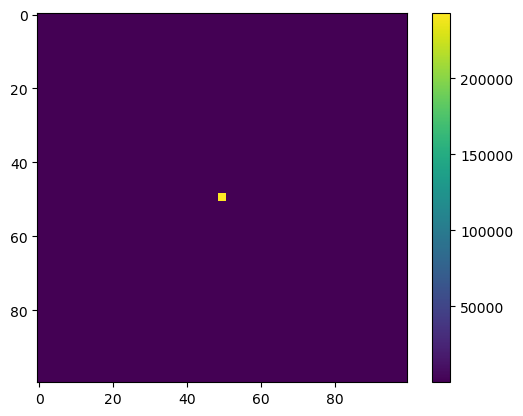

In [12]:
%pylab inline
imshow(q[0][0][50])
colorbar()
show()
imshow(q[0][-1][50])
colorbar()

In [13]:
cooling_table = np.genfromtxt("../../data/m-00.cie")
logT, logLambda_m20 = cooling_table[:,0],cooling_table[:,1]

from functools import partial
import jax
import jax.numpy as jnp
from jax import lax

#another attempt...
class AthenaCoolingForce:
    """
    Radiative cooling (and optional heating) as a source/forcing term, matching the
    Athena multiblast setup:
      - T < 1e4 K: Koyama & Inutsuka (2002) cooling (+ optional heating)
      - 1e4 K <= T <= 10^8.5 K: Sutherland & Dopita (1993) via tabulated log10 Λ(T)-20
      - T  > 10^8.5 K: linear extrapolation using last two table points
    Subcycling: 10 micro-steps per hydro step with early exit if t_cool large.
    Timestep limiter: min(ctime * |E/Edot|, dtmax), computed on current state.
    Units/coeffs match the uploaded Athena file; change if your units differ.
    """

    def __init__(
        self,
        equation_manager,
        pressure_fn,
        logT_table,                # shape [N], log10 T grid (monotonic, e.g. 4.0 .. 8.5)
        logLambda_m20_table,       # shape [N], values of (log10 Λ - 20) at logT_table
        *,
        # --- coefficients taken from Athena multiblast config (simulation units):
        ALPHA = 813.142554365,         # low-T cooling prefactor
        BETA  = 406571277.182611837,   # high-T cooling prefactor
        GAMMA = 406.571277183,         # low-T heating prefactor (toggle via include_heating)
        MHKB  = 115.98518596699539,    # m_H / k_B in code units
        include_heating = True,
        # timestep control used there:
        ctime = 1.0,       # coefficient (Athena stores this in ruser)
        dtmax = 1.0,       # ceiling (Athena stores this in ruser)
        temp_floor = 1.0e4,    # optional temperature floor (Athena uses ruser)
        subcycles = 30,    # 10 micro-steps like their NOSUBCYCLE guard
        early_exit = True, # early exit if t_cool > dt/ctime (as in their code)
        eps = 1e-30
    ):
        self.eq = equation_manager
        self.pressure_fn = pressure_fn
        self.logT = jnp.asarray(logT_table)
        self.logL = jnp.asarray(logLambda_m20_table)
        self.ALPHA = ALPHA
        self.BETA  = BETA
        self.GAMMA = GAMMA
        self.MHKB = MHKB
        self.include_heating = include_heating
        self.ctime = ctime
        self.dtmax = dtmax
        self.temp_floor = temp_floor
        self.subcycles = int(subcycles)
        self.early_exit = early_exit
        self.eps = eps

        # indices from equation manager (mass, momentum, energy)
        self.i_rho = self.eq.mass_ids
        # momentum indices not needed; we only touch thermal energy (via total energy slot)
        self.i_E   = self.eq.energy_ids

        # constants and thresholds used in Athena’s routine
        self._Tmin = 1.0e4
        self._Tmax = 10.0**8.5
        # convenience: factor 1.4/1.1 = 14/11 ≈ 1.272727... used in that file for T
        self._Tcoef = 14.0 / 11.0

    # -----------------------
    # Internal helpers
    # -----------------------
    def _finite_pos(self, x, floor):
        # use only finite & >0 entries; otherwise substitute a conservative floor
        return jnp.where(jnp.isfinite(x) & (x > 0.0), x, floor)
    
    def _T_phys(self, P, rho):
        # Athena’s temperature (Kelvin-like): (14/11)*(mH/kB)*P/rho
        rho_s = self._finite_pos(rho, self.eps)
        P_s   = self._finite_pos(P,   self.eps)
        return (14.0/11.0) * self.MHKB * P_s / rho_s
        
    def _temp_from_rhoP(self, rho, P):
        # T = (14/11) * (m_H / k_B) * P / rho   [matches the Athena file]
        return self._Tcoef * self.MHKB * P / jnp.maximum(rho, self.eps)

    def _Et_from_P(self, P, gamma):
        # Thermal energy density: Et = P / (gamma - 1); for gamma=5/3, Et=1.5 P
        return P / (gamma - 1.0)
        
    def _interp_logLambda_m20(self, logT):
        # assumes table grid is logT = 4.0 + 0.05*i  (i=0..N)
        p = jnp.floor((logT - 4.0) / 0.05).astype(int)
        p = jnp.clip(p, 0, self.logL.size - 2)
        q = (logT - 4.0) / 0.05
        y = self.logL[p]   * (q - 1.0 * p) + \
            self.logL[p+1] * (1.0 * p - q + 1.0)
        # above 10^8.5: extrapolate with the last two points (as Athena)
        over = logT > 8.5
        slope = 20.0 * (self.logL[-1] - self.logL[-2])
        y_over = slope * (logT - 8.5) + self.logL[-1]
        return jnp.where(over, y_over, y)

    def _cooling_heating_rate(self, rho, T):
        """
        Compute dotE (energy change rate density) following the Athena routine:
          dotE = rho^2 * [ -Λ(T)  +  (heating if enabled & T<1e4) ]
        Returns dotE in simulation units matching ALPHA/BETA/GAMMA usage.
        """
        T = jnp.where(jnp.isfinite(T), T, self._Tmin)
        T = jnp.clip(T, 1.0, self._Tmax)  # 

        logT = jnp.log10(jnp.maximum(T, self.eps))

        # Low-T branch (T < 1e4 K): Koyama & Inutsuka 2002 + optional heating
        low = T < self._Tmin
        # KI02 cooling piece:
        low_cool = self.ALPHA * rho * rho * (
            1.0e7 * jnp.exp(-118400.0 / (T + 1000.0)) + 0.014 * jnp.sqrt(jnp.maximum(T, 0.0)) * jnp.exp(-92.0 / jnp.maximum(T, self.eps))
        )
        # Kim & Ostriker 2015 heating:
        low_heat = jnp.where(self.include_heating, self.GAMMA * rho * rho, 0.0)
        dotE_low = -low_cool + low_heat

        # High-T table branch (1e4 <= T): Sutherland & Dopita 1993 (tabulated)
        y = self._interp_logLambda_m20(logT)  # y = log10 Λ - 20
       # y    = jnp.clip(y, -40.0, -10.0)      # i.e. Λ in [1e-40, 1e-10]×1e20

        Lambda = 10.0**y                       # this is dimensionless “Λ * 1e20” factor
        dotE_high = -self.BETA * rho * rho * Lambda

        return jnp.where(low, dotE_low, dotE_high)

    # -----------------------
    # Public API: dt limiter
    # -----------------------
    def timestep_old(self, U):
        W = self.eq.get_primitives_from_conservatives(U)
        rho = jnp.maximum(W[self.i_rho], self.eps)
        P   = jnp.maximum(W[self.i_E],   self.eps)
        gamma = getattr(self.eq, "gamma", 5.0/3.0)
        Et  = P / (gamma - 1.0)
    
        # Athena-style "physical" temperature used for rates
        T   = (14.0/11.0) * self.MHKB * P / rho
    
        # Use the floor only for the RATE; don't lift Et here
        T_eff  = jnp.maximum(T, self.temp_floor if self.temp_floor is not None else 0.0)
        dotE   = self._cooling_heating_rate(rho, T_eff)
    
        # Effective Et and |dotE| with floors to avoid 0/0 and absurd spikes
        Et_eff   = jnp.maximum(Et, self.eps)
        rate_eff = jnp.maximum(jnp.abs(dotE), 1e-30)
    
        tcool = Et_eff / rate_eff
    
        # Ignore cells already at/near the floor (cooling effectively turned off there)
        near_floor = (T <= (self.temp_floor if self.temp_floor is not None else 0.0) * 1.01)
        tcool = jnp.where(near_floor, jnp.inf, tcool)
    
        # Optional: absolute lower bound so one pathological cell doesn’t halt the sim
        tcool_floor = 1e-12  # code time units; tune to your problem
        tcool = jnp.maximum(tcool, tcool_floor)
    
        dt_cool = self.ctime * jnp.min(tcool)
        return jnp.minimum(dt_cool, self.dtmax)
        
    def timestep(self, U):
        rho = self._finite_pos(U[self.i_rho], self.eps)
        P   = self._finite_pos(self.pressure_fn(U), self.eps)
    
        gamma = getattr(self.eq, "gamma", 5.0/3.0)
        Et    = P / (gamma - 1.0)
    
        T     = self._T_phys(P, rho)
        T_eff = jnp.maximum(T, self.temp_floor if self.temp_floor is not None else 0.0)
    
        # dotE must be finite; guard T inside the rate too
        dotE  = self._cooling_heating_rate(rho, T_eff)
        rate  = jnp.maximum(jnp.abs(dotE), 1e-30)
    
        tcool = jnp.maximum(Et, self.eps) / rate
    
        # ignore cells at/near the floor so they don't collapse dt
        near_floor = (T <= (self.temp_floor if self.temp_floor is not None else 0.0) * 1.01)
        tcool = jnp.where(near_floor, jnp.inf, tcool)
    
        dt_cool = self.ctime * jnp.min(tcool)
        return jnp.minimum(dt_cool, self.dtmax)   
        
    def _thermo_from_U(self, U):
        # Use EquationManager to avoid unit/definition mismatches
        W = self.eq.get_primitives_from_conservatives(U)
        rho = jnp.maximum(W[self.i_rho], self.eps)
        P   = jnp.maximum(W[self.i_E],   self.eps)      # 'energy_ids' indexes pressure in primitives
        T   = self.eq.get_temperature(P, rho)
        gamma = getattr(self.eq, "gamma", 5.0/3.0)
        Et  = P / (gamma - 1.0)                         # thermal energy density
        return rho, P, T, Et, gamma

    # -----------------------
    # Public API: apply forcing
    # -----------------------

    def force(self, i_step, U, params, dt):
        # Conservative-to-thermo with finite guards (no EquationManager changes)
        rho = self._finite_pos(U[self.i_rho], self.eps)
        P   = self._finite_pos(self.pressure_fn(U), self.eps)
        gamma = getattr(self.eq, "gamma", 5.0/3.0)
    
        Et = P / (gamma - 1.0)
        T0 = self._T_phys(P, rho)
    
        # Early-exit heuristic evaluated at start (rate uses floored T)
        T_eff0 = jnp.maximum(T0, self.temp_floor if self.temp_floor is not None else 0.0)
        dotE0  = self._cooling_heating_rate(rho, T_eff0)
        tcool0 = jnp.maximum(Et, self.eps) / jnp.maximum(jnp.abs(dotE0), 1e-30)
        slow   = self.early_exit & (tcool0 > (dt / jnp.maximum(self.ctime, self.eps)))
    
        dt_loc = dt / float(self.subcycles)
        f_max  = 0.3  # lose at most 30% of Et per subcycle
    
        def body(i, carry):
            Tcur, Etcur = carry
    
            # ensure current state is finite/usable before rate eval
            Tcur  = jnp.where(jnp.isfinite(Tcur),  Tcur,  self.temp_floor if self.temp_floor is not None else 0.0)
            Etcur = jnp.where(jnp.isfinite(Etcur), Etcur, self.eps)
            Etcur = jnp.maximum(Etcur, self.eps)
    
            # RATE at floored temperature (no energy injection here)
      #      T_eff = jnp.maximum(Tcur, self.temp_floor if self.temp_floor is not None else 0.0)
            T_eff = jnp.maximum(Tcur, self.temp_floor or 0.0)
            near_floor = T_eff <= (self.temp_floor or 0.0) * 1.01
            dotE = jnp.where(near_floor, 0.0, self._cooling_heating_rate(rho, T_eff))
           # dotE  = self._cooling_heating_rate(rho, T_eff)
            dE    = dotE * dt_loc
    
            # fractional cap prevents overshoot to negative Et
            dE    = jnp.maximum(dE, -f_max * Etcur)
    
            Etnew = jnp.maximum(Etcur + dE, self.eps)
    
            Pnew  = (gamma - 1.0) * Etnew
            Tnew  = self._T_phys(Pnew, rho)
    
            # keep next state finite (without nan_to_num)
            Tnew  = jnp.where(jnp.isfinite(Tnew),  Tnew,  T_eff)  # fall back to rate-T if needed
            Etnew = jnp.where(jnp.isfinite(Etnew), Etnew, self.eps)
    
            return (Tnew, Etnew)
    
        T_sub, Et_sub = lax.fori_loop(0, int(self.subcycles), body, (T0, Et))
        Et_final = jnp.where(slow, jnp.maximum(Et + dotE0 * dt, self.eps), Et_sub)
    
        dE = Et_final - Et

        return U.at[self.i_E].add(dE)

In [14]:
#def pressure_from_manager(eq, U):
#    W = eq.get_primitives_from_conservatives(U)
#    # In your managers, primitives[energy_ids] is pressure; clamp numerically
#    return jnp.maximum(W[eq.energy_ids], eq.eps)
cooling_table = np.genfromtxt("../../data/m-00.cie")
logT, logLambda_m20 = cooling_table[:,0],cooling_table[:,1]
    
cool = dh.cooling.HeatCoolForce(
    equation_manager=eq,
    pressure_fn=lambda U: pressure_from_manager(eq, U),
    logT_table=logT,
    logLambda_m20_table=logLambda_m20,
    include_heating=True,
    early_exit= True,
    ctime= 0.2,
    dtmax= 1E10,
    temp_floor=100.0
)


In [15]:
from jax import Array 
from functools import partial
from typing import List
from diffhydro.solver.stencils import CentralSixthOrderReconstruction
from diffhydro.solver import recon



In [16]:
from diffhydro.solver.stencils import *
eq.cfl=0.3
eq.thermal_conductivity_model = "ELBADRY"
#eq.sutherland_parameters = [0.1, 1.0, 1.0]
#eq._set_transport_properties(None)
ss = dh.signal_speed_Rusanov
conductive_flux = dh.ConductiveFlux(eq, None, None,zeta= 5E-12,positivity=True)
conductive_flux.recon_head = CentralSixthOrderReconstruction()
solver = dh.HLLC(equation_manager=eq,signal_speed=ss)
cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"),positivity=True)
hydrosim = dh.hydro(n_super_step=int(40),fluxes=[cf], forces=[],use_mol=True,integrator='RK2')

#hydrosim = dh.hydro(n_super_step=int(600),fluxes=[cf,conductive_flux], forces=[cool],use_mol=True,integrator='RK2')


In [17]:
#sol[0]+np.random.randn(100,100,100)*1E-6

In [18]:
from scipy import ndimage

ic_filename = "multiblast.out3.00021.athdf"


ICs = athdf(athena_outputs_loc+ic_filename)

sol = jnp.zeros((5,100,100,100))
sol = sol.at[0].set(ICs["dens"])
sol = sol.at[1].set(ICs["mom1"])
sol = sol.at[2].set(ICs["mom2"])
sol = sol.at[3].set(ICs["mom3"])

sol = sol.at[-1].set(ICs["Etot"])

params = {}
q_cool = hydrosim.evolve_with_callbacks(sol,params)

In [19]:
#imshow(q_cool[0][-1][50])
import copy

In [570]:
eq.gamma

1.6

In [487]:
class ConductiveFlux:
    def __init__(self,
                EquationManager,
                 Solver,
                 Recon,
                 positivity = False,
                 zeta = 0
                ):
        self.eq_manage = EquationManager
        self.solver = Solver
        self.recon_heat = CentralSecondOrderReconstruction()
        self.zeta = zeta #5.111496271545331e-12
        self.positivity = positivity
        self.positivity_stencil = recon.WENO1()
        self.dx_o = 1
        
        try: #3d
            self.flux_shapes = (EquationManager.n_cons,EquationManager.mesh_shape[0],EquationManager.mesh_shape[1],EquationManager.mesh_shape[2])
        except: #2d, z velocity axis usually just constant...
            self.flux_shapes = (EquationManager.n_cons,EquationManager.mesh_shape[0],EquationManager.mesh_shape[1])

    def flux(self, sol, axis, params, flux):
        # primitives & temperature (cell-centered)
        prim = self.eq_manage.get_primitives_from_conservatives(sol)
        rho  = prim[self.eq_manage.mass_ids]
        p    = prim[self.eq_manage.energy_ids]
        T    = self.eq_manage.get_temperature(p, rho)

        ax0 = axis - 1  # 0-based spatial axis

        # --- face-centered temperature & primitives for kappa(T, prim) ---
        T_face   = self.recon_heat.reconstruct_xi(T, ax0)
        rho_face = self.recon_heat.reconstruct_xi(rho, ax0)
        p_face   = self.recon_heat.reconstruct_xi(p,   ax0)
        prim_face = prim.at[self.eq_manage.mass_ids].set(rho_face)\
                       .at[self.eq_manage.energy_ids].set(p_face)

        # unsaturated kappa at faces
        try:
            kappa_unsat = self.eq_manage.get_thermal_conductivity(T_face, prim_face, None, None, None)
        except TypeError:
            kappa_unsat = self.eq_manage.get_thermal_conductivity(T_face, prim_face)

        # --- temperature gradient at faces (collocated!) ---
        dT_dxi_face = (jnp.roll(T, -1, axis=ax0) - T) / self.dx_o  # lives at i+1/2 "slot"

        # --- saturation (El-Badry) uses |∇T| at faces, also collocated ---
        model = getattr(self.eq_manage, "thermal_conductivity_model", "")
        if model == "ELBADRY":
            # build face-aligned gradients in each dir
            dTdx_f = (jnp.roll(T, -1, axis=0) - T) / self.dx_o if (sol.ndim - 1) >= 1 else 0.0
            dTdy_f = (jnp.roll(T, -1, axis=1) - T) / self.dx_o if (sol.ndim - 1) >= 2 else 0.0
            dTdz_f = (jnp.roll(T, -1, axis=2) - T) / self.dx_o if (sol.ndim - 1) >= 3 else 0.0
            gradT_mag_face = jnp.sqrt(dTdx_f**2 + dTdy_f**2 + dTdz_f**2) + 1e-30

            cs_face = self.eq_manage.get_speed_of_sound(p_face, rho_face)
            kappa_max = 1.5 * cs_face**3 / (gradT_mag_face * self.zeta)
            kappa_used = 1.0 / (1.0/(kappa_unsat + 1e-30) + 1.0/(kappa_max + 1e-30)) * self.zeta / 1E4/2
        else:
            kappa_used = kappa_unsat

        # --- face flux with correct sign ---
        heat_flux_xi = - kappa_used * dT_dxi_face

        # pack into full flux array (only energy row nonzero)
        conductive_flux = jnp.zeros_like(sol)
        conductive_flux = conductive_flux.at[self.eq_manage.energy_ids].set(heat_flux_xi)
        return conductive_flux
    def timestep(self, sol):
        # Explicit diffusion CFL (safe in 1–3D)
        const = 0.1/100
        dx2 = float(self.dx_o) ** 2
    
        prim = self.eq_manage.get_primitives_from_conservatives(sol)
        rho  = prim[self.eq_manage.mass_ids]
        p    = prim[self.eq_manage.energy_ids]
        T    = self.eq_manage.get_temperature(p, rho)
        cp_m = self.eq_manage.get_specific_heat_capacity(T)  # per-unit-mass c_p
    
        # Unsaturated conductivity from the manager (face eval not required for dt)
        kappa_unsat = self.eq_manage.get_thermal_conductivity(T, prim)
    
        model = getattr(self.eq_manage, "thermal_conductivity_model", "")
    
        if model == "ELBADRY":
            # --- Use κ_eff only for El-Badry (saturation limiter) ---
            # Build |∇T| and c_s for κ_max
            dTdx = self.recon_heat.derivative_xi(T, 0) if (sol.ndim - 1) >= 1 else 0.0
            dTdy = self.recon_heat.derivative_xi(T, 1) if (sol.ndim - 1) >= 2 else 0.0
            dTdz = self.recon_heat.derivative_xi(T, 2) if (sol.ndim - 1) >= 3 else 0.0
            gradT = jnp.sqrt(dTdx*dTdx + dTdy*dTdy + dTdz*dTdz) + 1e-30
    
            cs = self.eq_manage.get_speed_of_sound(p, rho)
            ZETA = self.zeta  # same constant used in flux
            kappa_max = 1.5 * cs**3 / (gradT * self.zeta)
    
            # Harmonic combine for effective κ
            kappa_used = 1.0 / (1.0/(kappa_unsat + 1e-30) + 1.0/(kappa_max + 1e-30))* self.zeta / 8E3/2
    
            # El-Badry κ from your manager already contains a 1/ρ factor; do NOT divide by ρ again
            denom = jnp.maximum(cp_m, 1e-30)
    
        else:
            # --- Standard diffusion: use unsaturated κ and χ = κ/(ρ c_p) ---
            kappa_used = kappa_unsat
            rho_floor = jnp.maximum(rho, 1e-6)  # avoid ultra-low density blowups in dt
            denom = jnp.maximum(rho_floor * cp_m, 1e-30)
    
        chi = kappa_used / denom
        chi_max = jnp.max(chi)
    
        return const * dx2 / (chi_max + 1e-30)

In [344]:

ic_filename = "multiblast.out3.00021.athdf"


ICs = athdf(athena_outputs_loc+ic_filename)

sol = jnp.zeros((5,100,100,100))
sol = sol.at[0].set(ICs["dens"])
sol = sol.at[1].set(ICs["mom1"])
sol = sol.at[2].set(ICs["mom2"])
sol = sol.at[3].set(ICs["mom3"])

sol = sol.at[-1].set(ICs["Etot"])

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../../sims/multiblast.out3.00021.athdf', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [488]:
conductive_flux = ConductiveFlux(eq, None, None,zeta= 5.111496271545331e-12,positivity=True)
conductive_flux.recon_head = CentralSecondOrderReconstruction()

In [692]:
from jax import lax
class HeatCoolForce_alt:
    """
    Improved radiative cooling with robust overcooling protection.
    Key changes:
    - Fixed interpolation formula
    - Consistent temperature calculation
    - Per-substep floor enforcement preventing negative pressures
    - Better coordinated fractional limiters
    """

    def __init__(
        self,
        equation_manager,
        pressure_fn,
        logT_table,
        logLambda_m20_table,
        *,
        ALPHA = 813.142554365,
        BETA  = 406571277.182611837,
        GAMMA = 406.571277183,
        MHKB  = 115.98518596699539,
        include_heating = True,
        ctime = 1.0,
        dtmax = 1.0,
        temp_floor = 1.0e4,
        subcycles = 20,
        early_exit = True,
        eps = 1e-30
    ):
        self.eq = equation_manager
        self.pressure_fn = pressure_fn
        self.logT = jnp.asarray(logT_table)
        self.logL = jnp.asarray(logLambda_m20_table)
        self.ALPHA = ALPHA
        self.BETA  = BETA
        self.GAMMA = GAMMA
        self.MHKB = MHKB
        self.include_heating = include_heating
        self.ctime = ctime
        self.dtmax = dtmax
        self.temp_floor = temp_floor
        self.subcycles = int(subcycles)
        self.early_exit = early_exit
        self.eps = eps

        self.i_rho = self.eq.mass_ids
        self.i_E   = self.eq.energy_ids

        self._Tmin = 1.0e4
        self._Tmax = 10.0**8.5
        self._Tcoef = 14.0 / 11.0
        
        # Compute Et_floor once at initialization
        self.gamma = getattr(self.eq, "gamma", 5.0/3.0)
        self.Rgas  = getattr(self.eq, "R", 1.0)

    def _temp_from_rhoP(self, rho, P):
        """Single consistent temperature calculation method."""
        return self._Tcoef * self.MHKB * P / jnp.maximum(rho, self.eps)
#        return self.eq.get_temperature(P,rho)*1000
    def _Et_floor_from_rho(self, rho):
        """Compute minimum thermal energy density for given density."""
        if self.temp_floor is None:
            return 0.0
        Tf = self.temp_floor
        # Et = rho * R * T / (gamma - 1) for ideal gas
        return (rho * self.Rgas * Tf) / (self.gamma - 1.0)
        
    def _interp_logLambda_m20(self, logT):
        """Fixed interpolation formula."""
        # Grid spacing assumed to be 0.05
        idx_float = (logT - 4.0) / 0.05
        p = jnp.floor(idx_float).astype(int)
        p = jnp.clip(p, 0, self.logL.size - 2)
        
        # Correct linear interpolation
        frac = idx_float - p
        y = self.logL[p] * (1.0 - frac) + self.logL[p+1] * frac
        
        # Extrapolation above 10^8.5 K
        over = logT > 8.5
        slope = 20.0 * (self.logL[-1] - self.logL[-2])
        y_over = slope * (logT - 8.5) + self.logL[-1]
        
        return jnp.where(over, y_over, y)

    def _cooling_heating_rate(self, rho, T):
        """Compute energy change rate density (positive = heating, negative = cooling)."""
        logT = jnp.log10(jnp.maximum(T, self.eps))

        # Low-T branch: Koyama & Inutsuka 2002
        low = T < self._Tmin
        low_cool = self.ALPHA * rho * rho * (
            1.0e7 * jnp.exp(-118400.0 / (T + 1000.0)) + 
            0.014 * jnp.sqrt(jnp.maximum(T, 0.0)) * jnp.exp(-92.0 / jnp.maximum(T, self.eps))
        )
        low_heat = jnp.where(self.include_heating, self.GAMMA * rho * rho, 0.0)
        dotE_low = -low_cool + low_heat

        # High-T branch: Sutherland & Dopita 1993
        y = self._interp_logLambda_m20(logT)
        Lambda = 10.0**y
        dotE_high = -self.BETA * rho * rho * Lambda

        return jnp.where(low, dotE_low, dotE_high)

    def timestep(self, U):
        """Compute cooling timestep limit."""
        W = self.eq.get_primitives_from_conservatives(U)
        rho = jnp.maximum(W[self.i_rho], self.eps)
        P   = jnp.maximum(W[self.i_E],   self.eps)
        Et = P / (self.gamma - 1.0)
    
        T  = self._temp_from_rhoP(rho, P)
        T_eff = jnp.maximum(T, self.temp_floor if self.temp_floor is not None else 0.0)
    
        dotE = self._cooling_heating_rate(rho, T_eff)
        tcool = jnp.abs(Et / jnp.maximum(jnp.abs(dotE), self.eps))
        dt_cool = self.ctime * jnp.min(tcool)
        
        return jnp.minimum(dt_cool, self.dtmax)

    def force(self, i_step, U, params, dt):
        """
        Cooling/heating with per-substep floor enforcement.
        Key improvement: enforce Et >= Et_floor at every substep.
        """
        # Extract thermodynamic state
        W     = self.eq.get_primitives_from_conservatives(U)
        rho   = jnp.maximum(W[self.i_rho], self.eps)
        P     = jnp.maximum(W[self.i_E],   self.eps)
        Et0   = P / (self.gamma - 1.0)
        T0    = self._temp_from_rhoP(rho, P)
        
        # Compute floor per cell (density-dependent)
        Et_floor = self._Et_floor_from_rho(rho)
        Tf = self.temp_floor if self.temp_floor is not None else 0.0
        
        # --- Early-exit criterion ---
        T_eff0 = jnp.maximum(T0, Tf)
        dotE0  = self._cooling_heating_rate(rho, T_eff0)
        tcool0 = jnp.abs(Et0 / jnp.maximum(jnp.abs(dotE0), self.eps))
        
        # More conservative checks for early exit
        # Use 1.1× floor threshold (wider margin)
        near_floor0 = (T_eff0 <= 1.0 * Tf)
        
        # Check for sign flip
        dotE_raw0 = self._cooling_heating_rate(rho, T0)
        sign_flip = (dotE0 * dotE_raw0) < 0.0
        
        # Require small kick relative to Et AND to the margin above floor
        f_ee = 0.8  # conservative for early exit
        margin = Et0 - Et_floor
        small_kick = (jnp.abs(dotE0 * dt) <= f_ee * jnp.maximum(Et0, self.eps)) & \
                     (jnp.abs(dotE0 * dt) <= 0.5 * jnp.maximum(margin, self.eps))
        
        cand = tcool0 > (dt / jnp.maximum(self.ctime, self.eps))
        
        slow = (self.early_exit & cand & (~near_floor0) & (~sign_flip) & small_kick)
        
        # --- Subcycling path  ---
        dt_loc = dt / float(self.subcycles)
        
        def body(_, Et_cur):
            # Current state
            P_cur = (self.gamma - 1.0) * Et_cur
            T_cur = self._temp_from_rhoP(rho, P_cur)
            
            # Compute rate (use floor temperature if below)
            T_eff = jnp.maximum(T_cur, Tf)
            # Disable cooling/heating if already at floor
            near_floor = (T_cur <= 1.00001 * Tf)
            dotE = jnp.where(near_floor, 0.0, self._cooling_heating_rate(rho, T_eff))
            
            # Proposed update
            dE = dotE * dt_loc
            Et_new = Et_cur + dE
            

            # Additional fractional limiter for stability
            # (this is now secondary protection, floor is primary)
            abs_dE = jnp.abs(Et_new - Et_cur)
            max_frac_change = 0.95  # allow 50% change per substep max
            Et_new = jnp.where(
                abs_dE > max_frac_change * Et_cur,
                Et_cur + jnp.sign(Et_new - Et_cur) * max_frac_change * Et_cur,
                Et_new
            )
            
            return Et_new
        
        Et_sub = lax.fori_loop(0, int(self.subcycles), body, Et0)
            # KEY FIX: Enforce floor at every substep
            # This prevents cascading violations across substeps
        Et_sub = jnp.maximum(Et_sub, Et_floor)
            
        # --- Early-exit path (trapezoidal) ---
        # Predictor
        Et_pred = jnp.maximum(Et0 + dotE0 * dt, Et_floor)
        P_pred  = (self.gamma - 1.0) * Et_pred
        T_pred  = self._temp_from_rhoP(rho, P_pred)
        
        # Corrector
        dotE1 = self._cooling_heating_rate(rho, jnp.maximum(T_pred, Tf))
        
        # Trapezoidal update with conservative limiter
        dE_trap = 0.5 * (dotE0 + dotE1) * dt
        margin = Et0 - Et_floor
        dE_trap = jnp.clip(dE_trap, 
                          -f_ee * jnp.maximum(margin, self.eps),  # don't exceed margin to floor
                          f_ee * jnp.maximum(Et0, self.eps))      # don't heat too fast
        
        Et_slow = jnp.maximum(Et0 + dE_trap, Et_floor)
        
        # --- Select path ---
        Et_final = jnp.where(slow, Et_slow, Et_sub)
        
        # --- Write back ---
        dE = Et_final - Et0
        return U.at[self.i_E].add(dE)

In [698]:
cool2 = HeatCoolForce_alt(
    equation_manager=eq,
    pressure_fn=lambda U: pressure_from_manager(eq, U),
    logT_table=logT,
    logLambda_m20_table=logLambda_m20,
    include_heating=True,
    early_exit= True,
    ctime= 0.3,
    dtmax= 1E10,
    temp_floor=0.01
)

hydrosim_cool = dh.hydro(n_super_step=int(2000),
                    fluxes=[cf], 
                    forces=[cool2],
                    use_mol=True,
                    integrator='RK4',
                    snapshot_dir = "s_cool",
                    snapshot_every=100)

q_cool3 = hydrosim_cool.evolve_with_callbacks(copy.deepcopy(sol),params)


Shard shape: (5, 100, 100, 100)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}


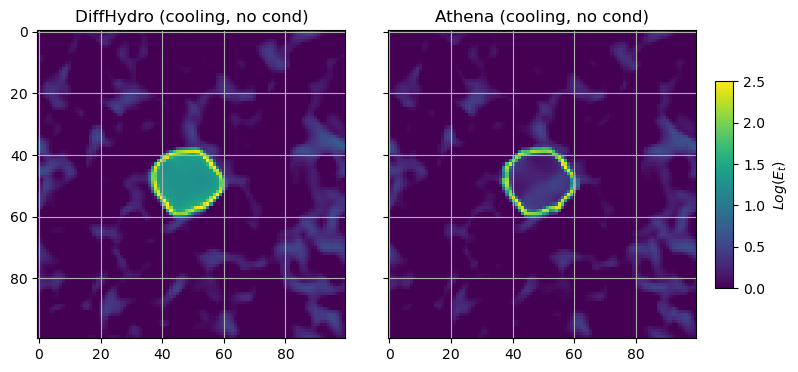

In [702]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

sn_out2 = shard_snaps.load_snapshot(hydrosim_cool,500)


#sn_out = shard_snaps.load_snapshot(hydrosim_cool,400)
fig,ax = plt.subplots(1,2,sharey=True,figsize=(9,4))
ax[0].imshow(np.log10(sn_out2[-1][50]),vmin=0,vmax=2.5)
ax[0].grid()
ax[0].set_title("DiffHydro (cooling, no cond)")

is_filename = "sn_cnc.out3.00121.athdf"

athena_outputs_loc = "../../sims/"

ISs = athdf(athena_outputs_loc+is_filename)

pcm1=ax[1].imshow(np.log10(ISs["Etot"][50]),vmin=0,vmax=2.5)
ax[1].grid()
ax[1].set_title("Athena (cooling, no cond)")


divider = make_axes_locatable( ax[1])
cax1 = fig.add_axes([0.90, 0.235, 0.02, 0.518])
plt.colorbar(pcm1, cax=cax1,label="$Log(E_t)$")
fig.subplots_adjust(hspace=0.01,wspace=0.01)
plt.savefig("cooling.pdf")
show()

In [668]:
print("hi!")

hi!


In [489]:


hydrosim = dh.hydro(n_super_step=int(2000),
                    fluxes=[cf,conductive_flux], 
                    forces=[cool],
                    use_mol=True,
                    integrator='RK4',
                    snapshot_dir = "s_cool_cond2",
                    snapshot_every=100)
q_cool2 = hydrosim.evolve_with_callbacks(copy.deepcopy(sol),params)


In [491]:
cf.timestep(q_cool2[0]),cool.timestep(q_cool2[0]),conductive_flux.timestep(q_cool2[0])

(Array(0.00184935, dtype=float32),
 Array(2.3207873e-19, dtype=float32),
 Array(0.00078129, dtype=float32))

In [69]:
W = cool.eq.get_primitives_from_conservatives(q_cool2[0])
rho = jnp.maximum(W[cool.i_rho], cool.eps)
P   = jnp.maximum(W[cool.i_E],   cool.eps)
Et = P / (cool.gamma - 1.0)

T  = cool._temp_from_rhoP(rho, P)
T_eff = jnp.maximum(T, cool.temp_floor if cool.temp_floor is not None else 0.0)

dotE = cool._cooling_heating_rate(rho, T_eff)
tcool = jnp.abs(Et / jnp.maximum(jnp.abs(dotE), cool.eps))
dt_cool = cool.ctime * jnp.min(tcool)

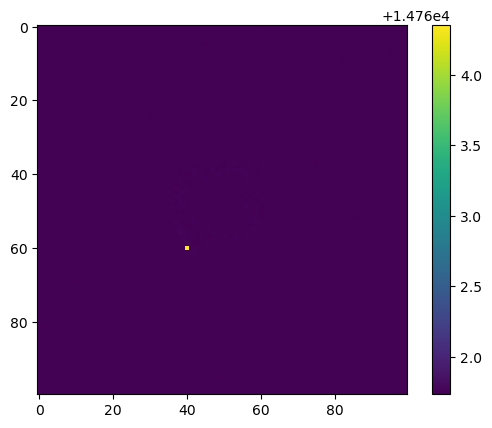

In [275]:
imshow(T_eff[49])
colorbar()

In [71]:
tcool.min(),T_eff.max()

(Array(0.0001085, dtype=float32), Array(14770.991, dtype=float32))

In [72]:
#q_cool3 = hydrosim.evolve_with_callbacks(copy.deepcopy(q_cool2[0]),params)


In [73]:
from diffhydro.utils.io import shard_snaps

prim = eq.get_primitives_from_conservatives(q_cool[0])
rho  = prim[0]
p    = prim[-1]
Ta   = eq.get_temperature(p, rho)

In [387]:
sn_out = shard_snaps.load_snapshot(hydrosim,1000)

prim = eq.get_primitives_from_conservatives(sn_out)
rho  = prim[0]
p    = prim[-1]
Tb    = eq.get_temperature(p, rho)

Shard shape: (5, 100, 100, 100)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}


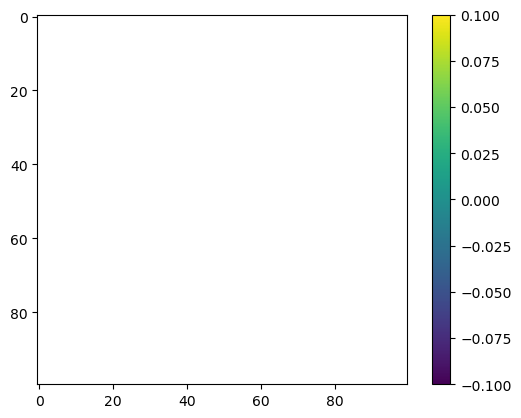

In [388]:
imshow(Tb[50])
colorbar()

In [76]:

is_filename = "multiblast.out3.02208.athdf"


ISs = athdf(athena_outputs_loc+is_filename)

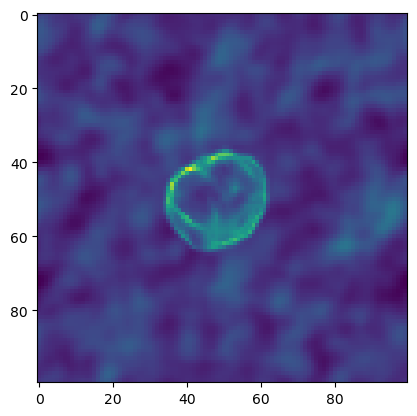

In [77]:
imshow(q_cool2[0][-1][:,:,:].sum(axis=1))


Shard shape: (5, 100, 100, 100)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}


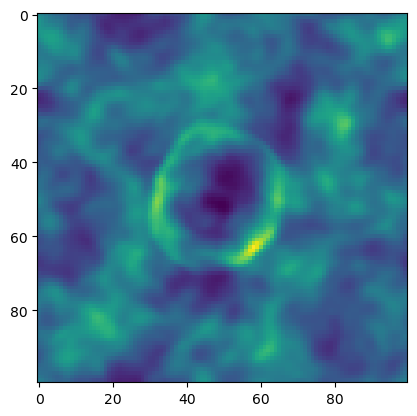

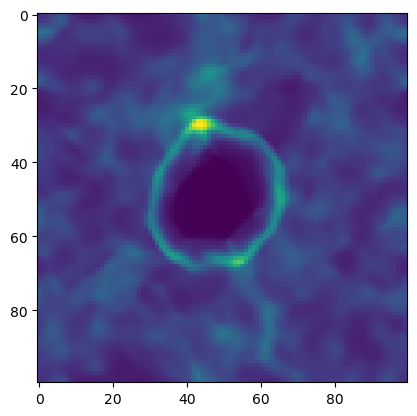

In [78]:
sn_out = shard_snaps.load_snapshot(hydrosim,19000)
imshow(sn_out[-1][:,:,:].sum(axis=2))
show()
imshow(sn_out[-1][:,:,50])

Shard shape: (5, 100, 100, 100)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}


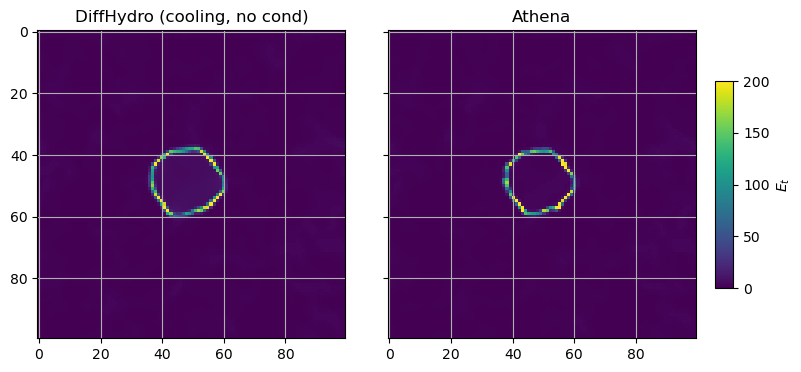

In [402]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

is_filename = "sn_cnc.out3.00121.athdf"

athena_outputs_loc = "../../sims/"

ISs = athdf(athena_outputs_loc+is_filename)

sn_out = shard_snaps.load_snapshot(hydrosim_cool,800)
fig,ax = plt.subplots(1,2,sharey=True,figsize=(9,4))
ax[0].imshow(sn_out[-1][50],vmin=0,vmax=200)
ax[0].grid()
ax[0].set_title("DiffHydro (cooling, no cond)")

pcm1=ax[1].imshow(ISs['Etot'][50],vmin=0,vmax=200)
ax[1].grid()
ax[1].set_title("Athena")


divider = make_axes_locatable( ax[1])
cax1 = fig.add_axes([0.90, 0.235, 0.02, 0.518])
plt.colorbar(pcm1, cax=cax1,label="$E_t$")
fig.subplots_adjust(hspace=0.01,wspace=0.01)
plt.savefig("cooling.pdf")
show()

In [238]:
sn_out = shard_snaps.load_snapshot(hydrosim,4500)

prim = eq.get_primitives_from_conservatives(sn_out)
rho  = prim[0]
p    = prim[-1]
T    = eq.get_temperature(p, rho)

Shard shape: (5, 100, 100, 100)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}


In [239]:

is_filename = "sn_cc.out3.00113.athdf"

athena_outputs_loc = "../../sims/"

ISs = athdf(athena_outputs_loc+is_filename)


In [240]:
athena_state = np.stack([ISs['dens'],ISs['mom1'],ISs['mom2'],ISs['mom3'],ISs['Etot']])

In [241]:
athena_state.shape

(5, 100, 100, 100)

In [242]:

prim = eq.get_primitives_from_conservatives(athena_state)
rho_ath  = prim[0]
p    = prim[-1]
T_athena    = eq.get_temperature(p, rho_ath)

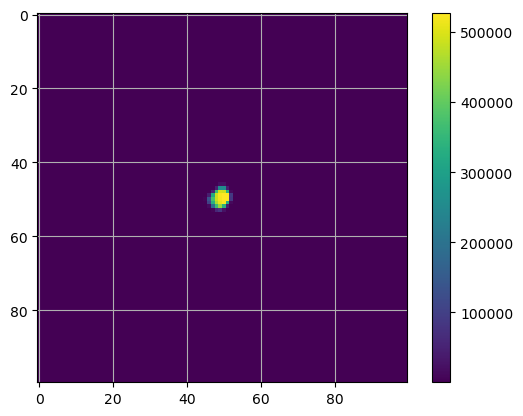

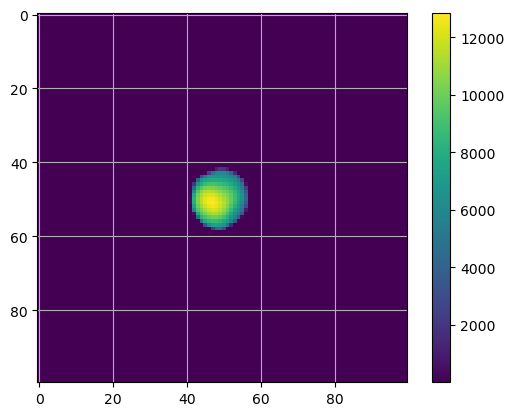

In [243]:
imshow(T[:,:,50])
grid()
colorbar()
show()
imshow(T_athena[:,:,50])
grid()

colorbar()

Shard shape: (5, 100, 100, 100)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}


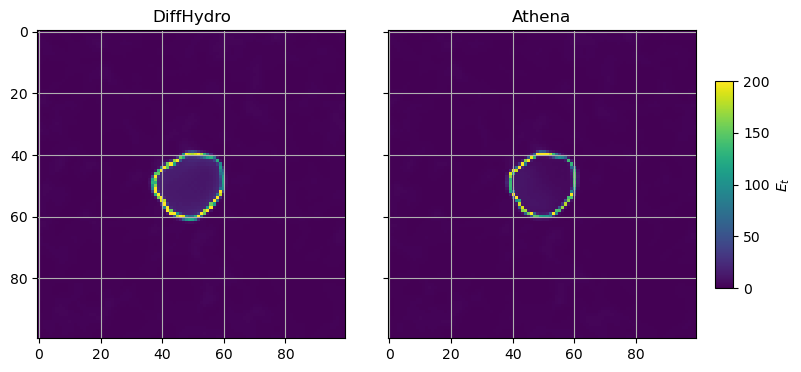

In [510]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

is_filename = "sn_cc.out3.00121.athdf"

athena_outputs_loc = "../../sims/"

ISs = athdf(athena_outputs_loc+is_filename)

sn_out = shard_snaps.load_snapshot(hydrosim,900)
fig,ax = plt.subplots(1,2,sharey=True,figsize=(9,4))
ax[0].imshow(sn_out[-1][:,50],vmin=0,vmax=200)
ax[0].grid()
ax[0].set_title("DiffHydro")

pcm1=ax[1].imshow(ISs['Etot'][:,50],vmin=0,vmax=200)
ax[1].grid()
ax[1].set_title("Athena")


divider = make_axes_locatable( ax[1])
cax1 = fig.add_axes([0.90, 0.235, 0.02, 0.518])
plt.colorbar(pcm1, cax=cax1,label="$E_t$")
fig.subplots_adjust(hspace=0.01,wspace=0.01)
plt.savefig("cooling.pdf")
show()

Shard shape: (5, 100, 100, 100)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}
Shard shape: (5, 100, 100, 100)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}


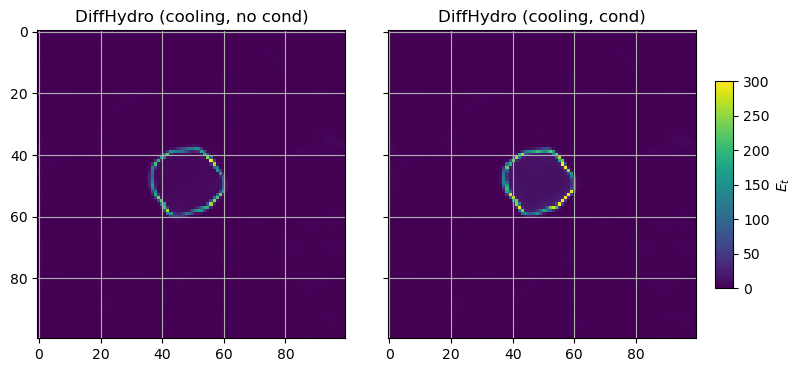

In [561]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

is_filename = "sn_cnc.out3.00121.athdf"

athena_outputs_loc = "../../sims/"

ISs = athdf(athena_outputs_loc+is_filename)

sn_out = shard_snaps.load_snapshot(hydrosim_cool,800)
fig,ax = plt.subplots(1,2,sharey=True,figsize=(9,4))
ax[0].imshow(sn_out[-1][50],vmin=0,vmax=300)
ax[0].grid()
ax[0].set_title("DiffHydro (cooling, no cond)")
sn_out2 = shard_snaps.load_snapshot(hydrosim,900)

pcm1=ax[1].imshow(sn_out2[-1][50],vmin=0,vmax=300)
ax[1].grid()
ax[1].set_title("DiffHydro (cooling, cond)")


divider = make_axes_locatable( ax[1])
cax1 = fig.add_axes([0.90, 0.235, 0.02, 0.518])
plt.colorbar(pcm1, cax=cax1,label="$E_t$")
fig.subplots_adjust(hspace=0.01,wspace=0.01)
plt.savefig("cooling.pdf")
show()

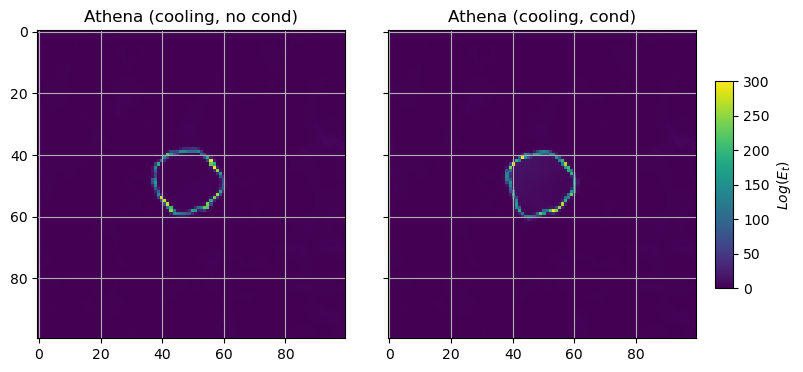

In [558]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

is_filename = "sn_cnc.out3.00121.athdf"

athena_outputs_loc = "../../sims/"

ISs = athdf(athena_outputs_loc+is_filename)

#sn_out = shard_snaps.load_snapshot(hydrosim_cool,400)
fig,ax = plt.subplots(1,2,sharey=True,figsize=(9,4))
ax[0].imshow(ISs["Etot"][50],vmin=0,vmax=300)
ax[0].grid()
ax[0].set_title("Athena (cooling, no cond)")

is_filename = "sn_cc.out3.00121.athdf"

athena_outputs_loc = "../../sims/"

ISs = athdf(athena_outputs_loc+is_filename)

pcm1=ax[1].imshow(ISs["Etot"][50],vmin=0,vmax=300)
ax[1].grid()
ax[1].set_title("Athena (cooling, cond)")


divider = make_axes_locatable( ax[1])
cax1 = fig.add_axes([0.90, 0.235, 0.02, 0.518])
plt.colorbar(pcm1, cax=cax1,label="$Log(E_t)$")
fig.subplots_adjust(hspace=0.01,wspace=0.01)
plt.savefig("cooling.pdf")
show()

Shard shape: (5, 100, 100, 100)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}
Shard shape: (5, 100, 100, 100)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}


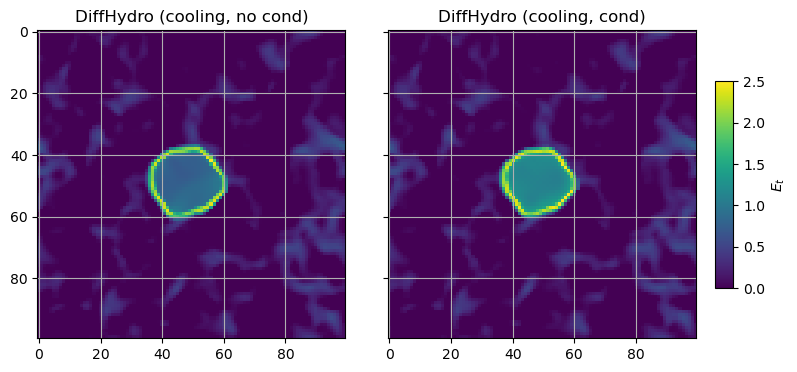

In [562]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

is_filename = "sn_cnc.out3.00121.athdf"

athena_outputs_loc = "../../sims/"

ISs = athdf(athena_outputs_loc+is_filename)

sn_out = shard_snaps.load_snapshot(hydrosim_cool,800)
fig,ax = plt.subplots(1,2,sharey=True,figsize=(9,4))
ax[0].imshow(np.log10(sn_out[-1][50]),vmin=0,vmax=2.5)
ax[0].grid()
ax[0].set_title("DiffHydro (cooling, no cond)")
sn_out2 = shard_snaps.load_snapshot(hydrosim,900)

pcm1=ax[1].imshow(np.log10(sn_out2[-1][50]),vmin=0,vmax=2.5)
ax[1].grid()
ax[1].set_title("DiffHydro (cooling, cond)")


divider = make_axes_locatable( ax[1])
cax1 = fig.add_axes([0.90, 0.235, 0.02, 0.518])
plt.colorbar(pcm1, cax=cax1,label="$E_t$")
fig.subplots_adjust(hspace=0.01,wspace=0.01)
plt.savefig("cooling.pdf")
show()

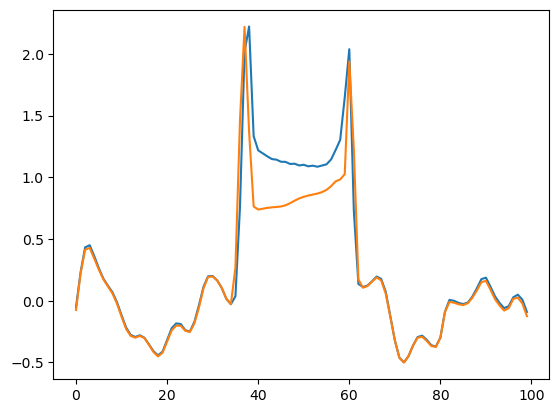

In [564]:
plt.plot(np.log10(sn_out2[-1][50][50]))
plt.plot(np.log10(sn_out[-1][50][50]))

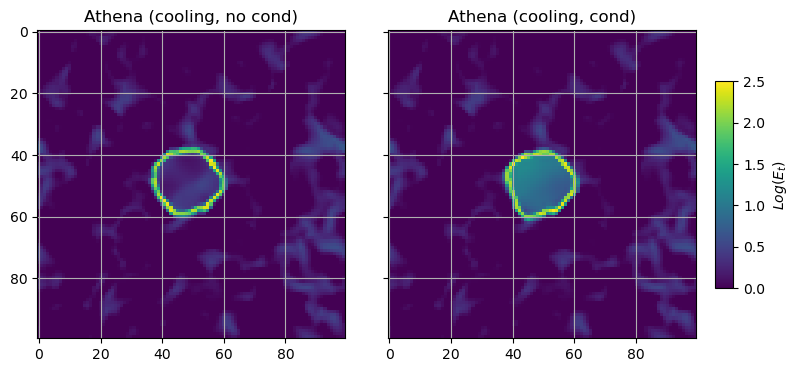

In [565]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

is_filename = "sn_cnc.out3.00121.athdf"

athena_outputs_loc = "../../sims/"

ISs = athdf(athena_outputs_loc+is_filename)

#sn_out = shard_snaps.load_snapshot(hydrosim_cool,400)
fig,ax = plt.subplots(1,2,sharey=True,figsize=(9,4))
ax[0].imshow(np.log10(ISs["Etot"][50]),vmin=0,vmax=2.5)
ax[0].grid()
ax[0].set_title("Athena (cooling, no cond)")

is_filename = "sn_cc.out3.00121.athdf"

athena_outputs_loc = "../../sims/"

ISs2 = athdf(athena_outputs_loc+is_filename)

pcm1=ax[1].imshow(np.log10(ISs2["Etot"][50]),vmin=0,vmax=2.5)
ax[1].grid()
ax[1].set_title("Athena (cooling, cond)")


divider = make_axes_locatable( ax[1])
cax1 = fig.add_axes([0.90, 0.235, 0.02, 0.518])
plt.colorbar(pcm1, cax=cax1,label="$Log(E_t)$")
fig.subplots_adjust(hspace=0.01,wspace=0.01)
plt.savefig("cooling.pdf")
show()

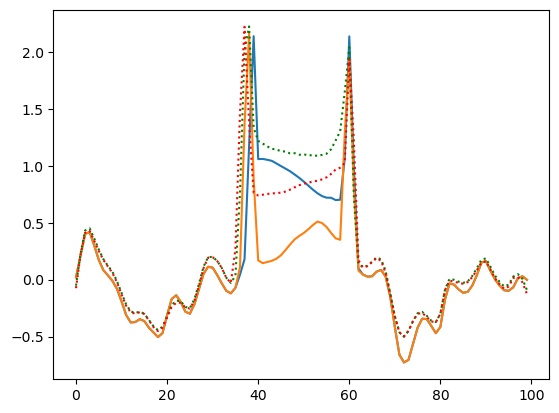

In [569]:
plt.plot(np.log10(ISs2["Etot"][50][50]))
plt.plot(np.log10(ISs["Etot"][50][50]))
plt.plot(np.log10(sn_out2[-1][50][50]),"g:")
plt.plot(np.log10(sn_out[-1][50][50]),"r:")

Shard shape: (5, 100, 100, 100)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}
Shard shape: (5, 100, 100, 100)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}


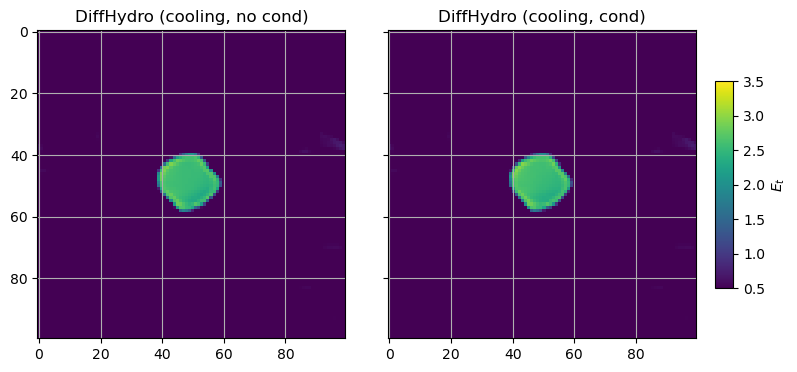

In [475]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

is_filename = "sn_cnc.out3.00121.athdf"

athena_outputs_loc = "../../sims/"

ISs = athdf(athena_outputs_loc+is_filename)

sn_out = shard_snaps.load_snapshot(hydrosim_cool,400)
#sn_out = shard_snaps.load_snapshot(hydrosim,1300)

fig,ax = plt.subplots(1,2,sharey=True,figsize=(9,4))
ax[0].imshow(np.log10(sn_out[-1][50]),vmin=0.5,vmax=3.5)
ax[0].grid()
ax[0].set_title("DiffHydro (cooling, no cond)")
sn_out2 = shard_snaps.load_snapshot(hydrosim,800)

pcm1=ax[1].imshow(np.log10(sn_out2[-1][50]),vmin=0.5,vmax=3.5)
ax[1].grid()
ax[1].set_title("DiffHydro (cooling, cond)")


divider = make_axes_locatable( ax[1])
cax1 = fig.add_axes([0.90, 0.235, 0.02, 0.518])
plt.colorbar(pcm1, cax=cax1,label="$E_t$")
fig.subplots_adjust(hspace=0.01,wspace=0.01)
plt.savefig("cooling.pdf")
show()

Shard shape: (5, 100, 100, 100)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}


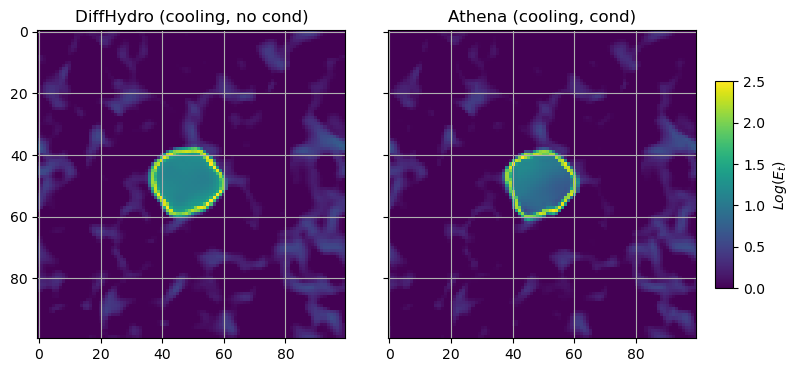

In [515]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

sn_out2 = shard_snaps.load_snapshot(hydrosim,900)


#sn_out = shard_snaps.load_snapshot(hydrosim_cool,400)
fig,ax = plt.subplots(1,2,sharey=True,figsize=(9,4))
ax[0].imshow(np.log10(sn_out2[-1][50]),vmin=0,vmax=2.5)
ax[0].grid()
ax[0].set_title("DiffHydro (cooling, no cond)")

is_filename = "sn_cc.out3.00121.athdf"

athena_outputs_loc = "../../sims/"

ISs = athdf(athena_outputs_loc+is_filename)

pcm1=ax[1].imshow(np.log10(ISs["Etot"][50]),vmin=0,vmax=2.5)
ax[1].grid()
ax[1].set_title("Athena (cooling, cond)")


divider = make_axes_locatable( ax[1])
cax1 = fig.add_axes([0.90, 0.235, 0.02, 0.518])
plt.colorbar(pcm1, cax=cax1,label="$Log(E_t)$")
fig.subplots_adjust(hspace=0.01,wspace=0.01)
plt.savefig("cooling.pdf")
show()

Shard shape: (5, 100, 100, 100)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}


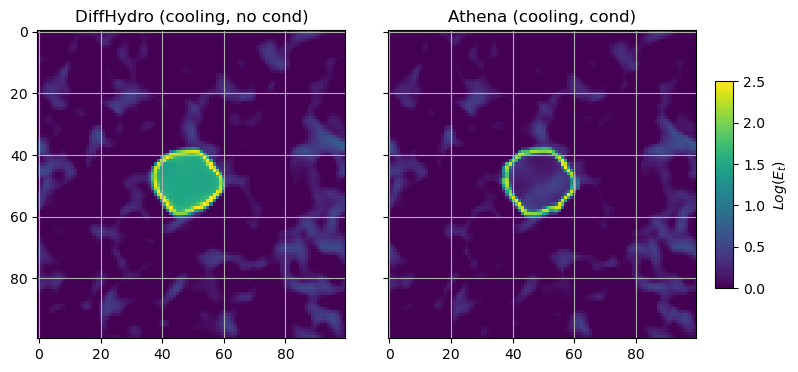

In [519]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

sn_out2 = shard_snaps.load_snapshot(hydrosim_cool,700)


#sn_out = shard_snaps.load_snapshot(hydrosim_cool,400)
fig,ax = plt.subplots(1,2,sharey=True,figsize=(9,4))
ax[0].imshow(np.log10(sn_out2[-1][50]),vmin=0,vmax=2.5)
ax[0].grid()
ax[0].set_title("DiffHydro (cooling, no cond)")

is_filename = "sn_cnc.out3.00121.athdf"

athena_outputs_loc = "../../sims/"

ISs = athdf(athena_outputs_loc+is_filename)

pcm1=ax[1].imshow(np.log10(ISs["Etot"][50]),vmin=0,vmax=2.5)
ax[1].grid()
ax[1].set_title("Athena (cooling, cond)")


divider = make_axes_locatable( ax[1])
cax1 = fig.add_axes([0.90, 0.235, 0.02, 0.518])
plt.colorbar(pcm1, cax=cax1,label="$Log(E_t)$")
fig.subplots_adjust(hspace=0.01,wspace=0.01)
plt.savefig("cooling.pdf")
show()